# 3 - Election Scenario

* Candidate A won the state by an average of 4% points, however they lost District 29 to candidate B by 22%, making it a significant outlier. 
* The final results for the distrct are 39% Candidate A, 61% Candidate B. 
* You are tasked to investigate this to determine if it is worth a thorough follow-up.
* You call a a hundred members of the general public who reported as voting. 48 out of the 100 reported voting for Candidate A. 
* What do you report?

# proportion testing


In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from scipy.stats import norm

But what question are we actually wanting to answer? Maybe this is a good one:

*What is the chance that more than Candidate A got more votes than reported?*

Or to put this another way: 
* Null Hypothesis - 39% of votes went to Candidate A and 61% to Candidate B
* Alternative Hypothesis - >39% of votes went to Candidate A and <61% to Candidate B

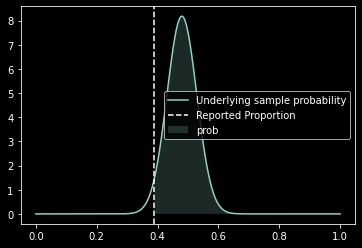

In [2]:
# proportion testing: Binomial dist,, want tp approximate it as a Normal and run tests on the Normal instead of the binomial. Do we have enough samples for that.
sigma = np.sqrt(0.39 * 0.61 / 100) #39% for A, 61% for B, WE asked 100 people what they voted. (The width) #Binomial dist
reported = 0.39 #from the population
sample = 0.48 #from the sample of 100 people

xs = np.linspace(0, 1, 500) #percentages from 0 to 1
ps = norm.pdf(xs, sample, sigma) # probability , Normal dist . mean= sample ,, width(std)= sigma    #the dist At the sample mean(48) NOT the reported value(39).
plt.plot(xs, ps, label="Underlying sample probability")
plt.axvline(reported, ls="--", label="Reported Proportion")   #Vertical line at the reported percentage 39 %
plt.fill_between(xs, ps, 0, alpha=0.2, where=xs>=reported, label="prob")
plt.legend();
# to answer the question,,  what is the chance given this sample that More than 39% actually Voted for candidate A [And there's cheating]
#We get the prob we need Area under the curve from the vertical line all away to the right

In [3]:
reported = 0.39
sample = 0.48 
# All the above plot tells us is that things might indeed look fishy. But lets look into the CDF 
# for specifics and then quantify the probability.
prob_more = norm.sf(reported, sample, sigma)        #From reported all way to the right # if we reversed reported and sample you get p-value
print(f"There is a {100 * prob_more:.1f}% chance that Candidate A would have received more votes")
# High percentage ,, Reject the null hypothesis (that Every thing is fair)

There is a 96.7% chance that Candidate A would have received more votes


In [4]:
#If we want to phrase this in terms of z-scores for a one-tail test and checking if we have
# a p-value of < 0.05 .. To Reject the null hypo
z_score = (sample - reported) / sigma                   #z_score = (sample mean - hyopthesis mean) / standard error[sigma]
z_score_needed_for_significance = norm.ppf(0.95)     #What value of x gives you 95% of the Area in the CDF
print(f"if {z_score:.3f} is larger than {z_score_needed_for_significance:.3f}, we are significant")
print(f"Have p-value {norm.sf(sample, reported, sigma):.3f}") #p-value less than 0.05, we can reject the Null hypo

if 1.845 is larger than 1.645, we are significant
Have p-value 0.033


So what does this mean? We should probably tell our supervisors that this is a significant result (p < 0.05) and warrants a deeper investigation.

Follow up: What if instead of asking *What is the chance that more than Candidate A got more votes than reported?*, we instead asked *What is the chance that more than Candidate A got a significantly different amount of votes than reported?*

Ie we now move from the one-tail case to the two-tailed? Let's continue assuming someone has asked if it meets $p = 0.05$ criteria

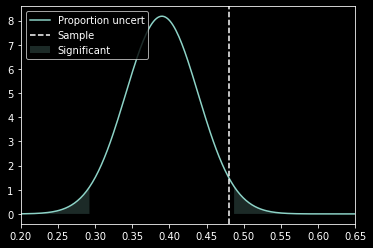

In [5]:
xs = np.linspace(0, 1, 500)
ps = norm.pdf(xs, reported, sigma)    #PDF of the population not sample

plt.plot(xs, ps, label="Proportion uncert")
plt.axvline(sample, ls="--", label="Sample")
limits = norm.ppf([0.025, 0.975], reported, sigma) # [0.025, 0.975] Limits used to generate the grean area,, Gives p-value=0.05 , half right and half left
plt.fill_between(xs, ps, 0, alpha=0.2, where=(xs<limits[0])|(xs>limits[1]), label="Significant")
plt.legend(loc=2)
plt.xlim(0.2, 0.65);
# if we have a p-value=0.05 then our result become significance if it lies in the small grean area
# The vertical line doesn't intersect the area of significance, WE ARE NOT GOING TO HAVE THE SIGNIFICANCE

In [6]:
# So it looks like it's not 𝑝 < 0.05 significant for the two-tailed case. Or more formally:
# Using z-scores
z_score = (sample - reported) / sigma  # Same as before
z_score_needed_for_significance = norm.ppf(0.975) 
print(f"{z_score:.3f} is less than {z_score_needed_for_significance:.3f}, so we aren't significant")

# Using p-values
p_value_two_tailed = 2 * norm.sf(z_score) # 2 because we are now care about 2 areas
print(f"{p_value_two_tailed:.3f} is > 0.05")
#It's all okay and no cheating.

1.845 is less than 1.960, so we aren't significant
0.065 is > 0.05


significance means below 0.05 and reject the null hypothesis.
Same Data but 1-tail test and it's significance. AND 2-tailed test and it's not.

*************

# 4 - Pearson's $\chi^2$ Test

Last time we tried to answer the question *"Is Tommy rolling too many sixes?"*.
# Comparing Distributions
Now, time to ask a different question. What if we're not worried about just the number of sixes, but what to ask *"Is the distribution of rolls we get consistent with a fair die?"*

The Pearson's $\chi^2$ test for rolling a die gives

$$ \chi^2 = \sum_{i=1}^{6} \frac{(C_i - E_i)^2}{E_i} $$

Chi-Squared distribution

Chi-squared test ONLY APPLYES TO DISCRET DISTRIBUTIONS (BINOMIAL,UNIFORM)

But what does this $\chi^2$ value mean? We can convert it to a probability given the $\chi^2$ (chi-square) distribution with 5 degrees of freedom (six sides - 1)

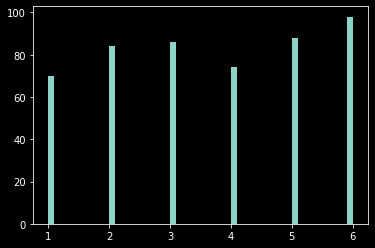

In [7]:
import numpy as np
import matplotlib.pyplot as plt

data = np.loadtxt("loaded_500.txt")
unique, counts = np.unique(data, return_counts=True)
plt.hist(data, bins=50);

In [8]:
#data

In [9]:
expected = data.size / 6  #expected num of sixes for a fair dice
chi2_val = np.sum((counts - expected)**2 / expected) # The above equation
print(chi2_val)

6.112


Our p-value is 0.295


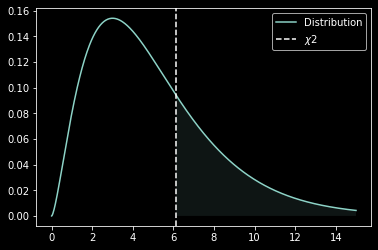

In [10]:
from scipy.stats import chi2
chi2s = np.linspace(0, 15, 500)
prob = chi2.pdf(chi2s, 5) # prob for 5 degrees of freedom (the distribution)

plt.plot(chi2s, prob, label="Distribution")
plt.axvline(chi2_val, label="$\chi2$", ls="--")
plt.fill_between(chi2s, prob, 0, where=(chi2s>=chi2_val), alpha=0.1)
plt.legend();
print(f"Our p-value is {chi2.sf(chi2_val, 5):.3f}")

In [11]:
from scipy.stats import chisquare
chisq, p = chisquare(counts, expected)
print(f"We have a chi2 of {chisq:.2f} with a p-value of {p:.3f}")
# in the first question we had significance , we looked only on number of sixes. we Tested just one thing
#in this test We don't have significance , here we looked at the entire distribution

We have a chi2 of 6.11 with a p-value of 0.295


This leads to an interesting point. In the first test with only number of sixes, we had significance. In the last test, we only care about the occurence of sixes. In this example, our statistical power was spread out over many faces. Both tests are valid. Be careful about finding many ways to test a hypothesis - this is called "significance hunting".

In general, the more specific your "question", the more powerful a test you can use.

Also, whilst in this example we used a one-sided distribution (which is asking the question if our observed distrubition is *too discrepant* from the underlying), we could also use a two-sided distribution, which also tests to see if our observed distribution is *too similar* from the underlying. For example, imagine rolling a dice 600 times and getting exactly. 100 of each number. And then getting that result when you do it again and again. With random numbers, there is such a thing as being too perfect.

*************

# 5 - Loaded dice distributions

What if we can't observe a single roll. What if the dice get rolled, in this case, in sets of 10 at a time , and all we have is the total(sum of 10 rolls). The distribution of a `10d6` is not trivial! 

In fact, it is probably easier to calculate this distribution numerically rather than doing it analytically.. Continous distributions

****

**What if we don't know the analytic distribution?**

Here we'll briefly look at the Kolmogorov-Smirnov test. But please note, it is meant for *continuous* distributions, I am using it on a discrete one simply to make it similar to previous examples, but you wouldn't do this if you wanted confidence in the results. In fact, the reason we are using 10 dice added together is to make our discrete distribution continuous enough.

In [3]:
# ks test
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')

rolls_obs = np.loadtxt("loaded_many_100.txt")  # Observed data
unique, count_obs = np.unique(rolls_obs, return_counts=True) #Num of each outcome we get
count_obs = count_obs / count_obs.sum()  # Noramlise to looks like a PDF

In [4]:
#what should we expect to see if the null hypo is true, if we have 10 fair dice that were rolling and adding up all the number 
rolls_fair = np.random.randint(low=1, high=7, size=(500000, 10)).sum(axis=1)  # 10 rolls 500000 times and sum each 10  (predicted data) 
unique2, count_fair = np.unique(rolls_fair, return_counts=True)
count_fair = count_fair / count_fair.sum()  # Noramlise 

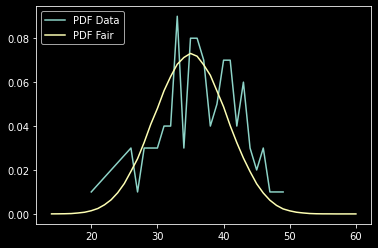

In [5]:
plt.plot(unique, count_obs, label="PDF Data") # doesn't look like normal,, only 100 data points (few)
plt.plot(unique2, count_fair, label="PDF Fair") #close to normal dist
plt.legend()
plt.legend(loc=2);

This looks really messy. So here's a first tip when you're comparing distributions. If you compare the PDF, you have to bin the results and its hard to get insights unless you have a *lot* of data.

Instead, plot the CDF. You don't need to bin the data anymore.

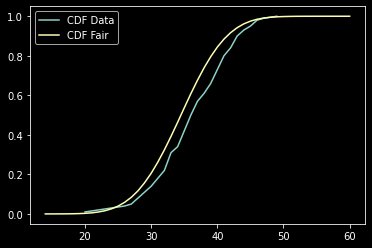

In [6]:
cdf_obs = count_obs.cumsum()
cdf_fair = count_fair.cumsum()
plt.plot(unique, cdf_obs, label="CDF Data")
plt.plot(unique2, cdf_fair, label="CDF Fair")
plt.legend(loc=2);

# KS test

In [7]:
#ks test: Create 2 emprical CFD fun, 1 for each data distribution passed in (The above graph) and see for each X value what is the difference between 
# the CDFs at that point(height of vertical line between the 2) and see what is the biggest line of all of them. THAT'S IT [Max distance between the 2 CDF fun] 
#p-value is the probability of getting this distance if the 2 distributions were drown from the same population
# when they start to go away from each other, that's evedince that observer data(rolls_obs) didn't come from the distribution(rolls_fair) and can reject the null
# hypo that one is drown from the other 
from scipy.stats import ks_2samp  #takes 2 sets of observations, create the emprical CDF of both and compare them
statistic, pvalue = ks_2samp(rolls_obs, rolls_fair)
print(f"KS test statistic of {statistic:.3f}, p-value of {pvalue:.3f}")
#p-value is less than 0.05 , we have significant evidence that these dice are not fair,, BUT KS test is not perfect

KS test statistic of 0.135, p-value of 0.047


# Anderson-Darling Test

An improvement on the KS test that gives more weight to the tails of the distribution (whilst the K-S test gives more weight in the center). The default test requires testing against analytic distributions (like the KS test), however you can also test two observed distributions.

In [17]:
from scipy.stats import anderson_ksamp #can use it to more than 2 sets
statistic, critical_values, sig_level = anderson_ksamp([rolls_obs, rolls_fair])  #sig_level is the p-value
print(f"AD test statistic of {statistic:.5f}, sig-level of {sig_level:.9f}")

print(f"Test critical values are {critical_values}") #Set of critical values for the test statistics for different thresholds of confidence
print("Sig-level analgous to p-value, and critical values are [25%, 10%, 5%, 2.5%, 1%]")  

# Just use the statistics and p-value (sig_level)

AD test statistic of 5.20690, sig-level of 0.002925997
Test critical values are [0.325 1.226 1.961 2.718 3.752 4.592 6.546]
Sig-level analgous to p-value, and critical values are [25%, 10%, 5%, 2.5%, 1%]


# Always use AD test. Better than KS test when comparing distributions.